# Par 4: Lean Theorem Classification with a Convolutional Neural Network

To begin, first include a dataset of Lean Theorem and Category Classification Pairs. If you are using our datset, look for the CSV files in the directory. 

In [2]:
#Import all needed libraries

import csv
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

Read in the data from CSV

In [3]:
file = 'all_theorem_classes_2.csv' #Many different iterations of dataset after processing, change to see

data = []

with open(file, mode='r', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # first row is column labels
    for row in csvreader:
        data.append((row[0], row[1]))

# first shuffle the data before splitting
random.seed(229)
random.shuffle(data)


#categories is our y_labels, and theorems is our x data
categories = []
theorems = []

for (label, thm) in data:
    categories.append(label)
    theorems.append(thm)

In [4]:
#Previously considered procedure to ignore theorems of insufficient length. Archived for now.

# theoremsM = []
# categoriesM = []
# for i in range(len(theorems)):
#     if len(theorems[i]) > 50:
#         theoremsM.append(theorems[i])
#         categoriesM.append(categories[i])
# theorems = theoremsM
# categories = categoriesM

Next, using the Keras' library inbuilt text tokenizer, we can format Lean statements as sequences of integers. Each unique character string will be mapped to a unqiue integer, consistent across the whole dataset. 

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(theorems)
#Save tokenized sequences
sequences = tokenizer.texts_to_sequences(theorems)

The CNN network architecture only takes in 1D vector input of a fixed length. However, our Lean theorems come in varying lengths. To workaround this issue, we fix out input length to be the longest sequence. Then, all inputs will be artificially extended to this length by adding zeros at the end. Fortunately, Keras has an inbuilt function to do this. 

In [6]:
longest_theorem = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=longest_theorem, padding='post')
print(longest_theorem)

234


Now, we also make the label data. This is the category of each theorem, which will be interpreted as a class for classification. These classes will be encoded as one-hot vectors, enabling easy error loss calculation using softmax.

In [7]:
indexs = {category: i for i, category in enumerate(set(categories))}
labels = [indexs[category] for category in categories]

#We make use of Keras' inbuitl utility function to_categorical to create our one-hot encodings. The outpout is a matrix n x l, where n is the length of our dataset and l is the number of labels.
categorical_labels = to_categorical(labels)
print(len(categorical_labels[0]))
# print(len(indexs))

28


In [8]:
# We first split the data to obtain a validation set
X_train, X_valid, y_train, y_valid = train_test_split(padded_sequences, categorical_labels, test_size=0.2) #Sets aside validation set of size 20%
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25) #Sets aside test set of size 0.8 * 0.25 = 20%

#For verification, print out the shapes of our dataset
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(53201, 234)
(53201, 28)
(17734, 234)
(17734, 28)
(17734, 234)
(17734, 28)


Here, we define hyperparameters for model tuning. It's important to note these parameters are adjusted PRIOR to testing

In [9]:
vocab_size = len(tokenizer.word_index) + 1  # Number of unique tokens
embedding_dim = 100 #Length of embedding vector
num_filters = 128 #Number of filters for convolution
kernel_size = 5  #Number of filters
num_categories = len(indexs)  # Number of unique categories
lr = 0.001 #learning rate
batch= 30 #batch size

We define a Convolution Nueral Network to fit our case. This matches our number of unique tokens, intended embedding dimension, activation function ReLU, etc.

In [15]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(num_categories, activation='softmax'))

Now, we will test various learning rates on the validation set. The best performing option will be used in the testing set. 

In [11]:
learning_rates = [0.00005, 0.0001, 0.001, 0.01, 0.05]

We run the model fitting for each learning rate, and save the epoch accuracy and loss history for each

In [11]:
history = {} #Dictionary to store our loss values across the various parameters
for lr in learning_rates:
    model.compile(optimizer=Adam(learning_rate=lr, epsilon = 0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
    training = model.fit(X_train, y_train, batch_size = batch, epochs=10, validation_data=(X_valid, y_valid))
    history[lr] = training.history

Epoch 1/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2007 - loss: 2.8180 - val_accuracy: 0.3397 - val_loss: 2.2328
Epoch 2/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.3795 - loss: 2.0902 - val_accuracy: 0.4815 - val_loss: 1.8152
Epoch 3/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5222 - loss: 1.7120 - val_accuracy: 0.5789 - val_loss: 1.5433
Epoch 4/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.6115 - loss: 1.4342 - val_accuracy: 0.6520 - val_loss: 1.3162
Epoch 5/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.6844 - loss: 1.2106 - val_accuracy: 0.7036 - val_loss: 1.1315
Epoch 6/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7359 - loss: 1.0265 - val_accuracy: 0.7380 - val_loss: 0.9861
Epoch 7/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7696 - loss: 0.8870 - val_accuracy: 0.7659 - val_loss: 0.8738
Epoch 8/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8002 -

In [16]:
print(history[0.01].keys()) #Verify losses were saved in History

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Now, we want to plot the training loss and accuracy. At the same time, we plot the validation values to compare for overfitting. 

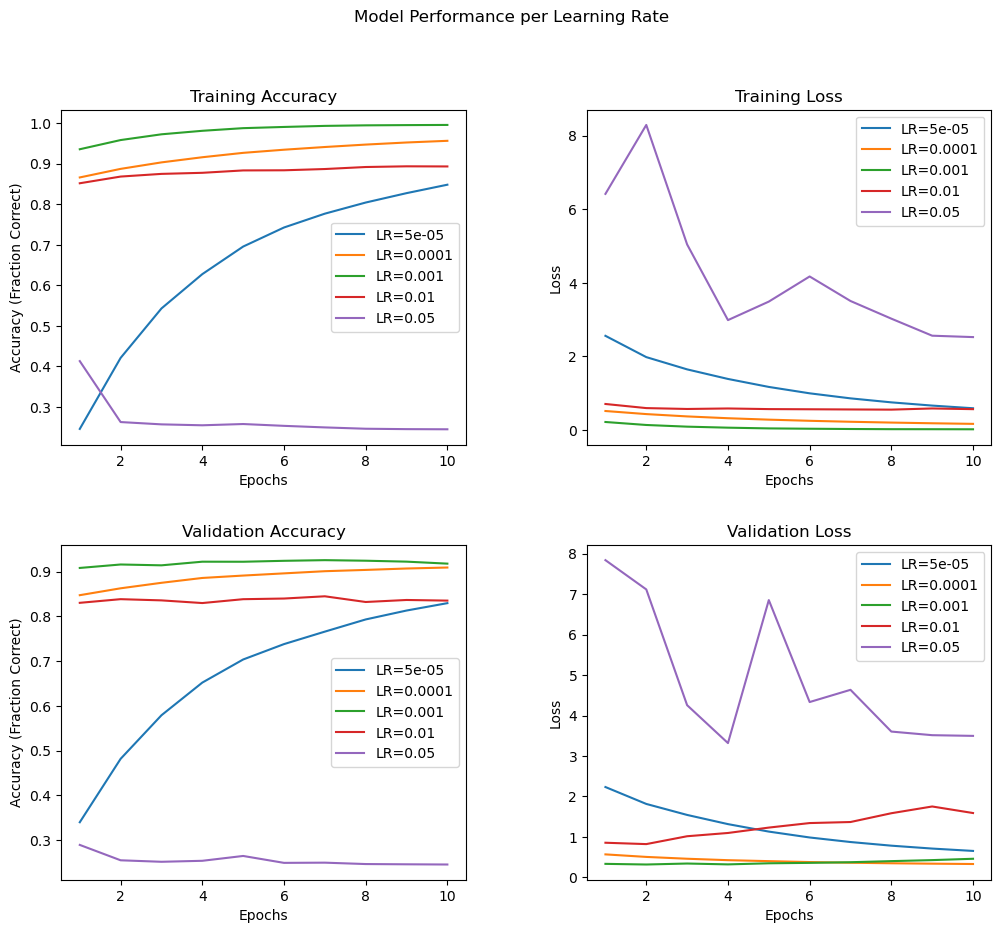

In [21]:
#Define 4 plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

#Our Big title
fig.suptitle('Model Performance per Learning Rate')

plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Define range of epochs for our x-axis
epochs = range(1, 11)  

# titles
titles = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss']

# the history keys for our dataset
data_keys = ['accuracy', 'loss', 'val_accuracy', 'val_loss']


#Plot all 4 graphs, iterating over the axis and index for coordinate
for idx, (ax, title, key) in enumerate(zip(axs.flat, titles, data_keys)):
    for lr, hist in history.items():
        ax.plot(epochs, hist[key], label=f'LR={lr}') #actual plot
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    #labels
    if idx % 2 == 0:
        ax.set_ylabel('Accuracy (Fraction Correct)')
    else :
        ax.set_ylabel('Loss')
    ax.legend()

plt.show()

From our test, we determine that the model performs the best against the validation set for learning rate 0.001. Using this learning rate, we next look to tune the number of epochs of training.

We do this by running the model again, with our learning rate, and finding the epoch with minimum validation loss. We train for this long in the testing phase

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001, epsilon = 0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
training = model.fit(X_train, y_train, batch_size = batch, epochs=10, validation_data=(X_valid, y_valid))
training_history = training.history

Epoch 1/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5676 - loss: 1.5315 - val_accuracy: 0.8729 - val_loss: 0.4426
Epoch 2/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9110 - loss: 0.3063 - val_accuracy: 0.9077 - val_loss: 0.3141
Epoch 3/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9519 - loss: 0.1597 - val_accuracy: 0.9204 - val_loss: 0.2766
Epoch 4/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9718 - loss: 0.0946 - val_accuracy: 0.9250 - val_loss: 0.2770
Epoch 5/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9803 - loss: 0.0632 - val_accuracy: 0.9231 - val_loss: 0.2934
Epoch 6/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9888 - loss: 0.0396 - val_accuracy: 0.9277 - val_loss: 0.3014
Epoch 7/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9923 - loss: 0.0270 - val_accuracy: 0.9297 - val_loss: 0.3217
Epoch 8/10
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9952 -

Now, we plot our validation loss with this configuration and note the optimal training duration

In [21]:
#We plot with the same configuration as before, but for one plot

plt.figure(figsize=(10, 6))

epochs = 10 #x axis
plt.plot(range(epochs), training_history['val_loss'], label='Validation Loss')
plt.plot(range(epochs), training_history['loss'], label='Training Loss')

best = np.argmin(training_history['val_loss']) #best epoch
# plt.xlim(0,19)
plt.plot([best for _ in range(11)], [0.1 * i for i in range(11)], linewidth = 3, linestyle = 'dashed', color = 'red', label="Ideal Training Cutoff") #plot a v-line
plt.xticks(range(0,10))
plt.title('Validation Loss Epoch Tuning')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

Given our optimal learning rate of 0.001 and epochs of 3 and batch size of 30, we finally test on the test set. 

In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(num_categories, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001, epsilon = 0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit(X_train, y_train, batch_size = batch, epochs=3, validation_data=(X_valid, y_valid))
training_history = training.history

Epoch 1/3
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.5583 - loss: 1.5688 - val_accuracy: 0.8717 - val_loss: 0.4521
Epoch 2/3
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9069 - loss: 0.3248 - val_accuracy: 0.9054 - val_loss: 0.3191
Epoch 3/3
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9535 - loss: 0.1613 - val_accuracy: 0.9169 - val_loss: 0.2899


Finally, we test our model on our test set, 

In [37]:
y_pred_probs = model.predict(X_test)
#change from one-hot encodings to integers
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1) 


555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [38]:
print(set(y_true)) #confirm our classes are all of them

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


In [39]:
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true') #Create a confusion matrix with nromalization to highlight accuracy for EACH class

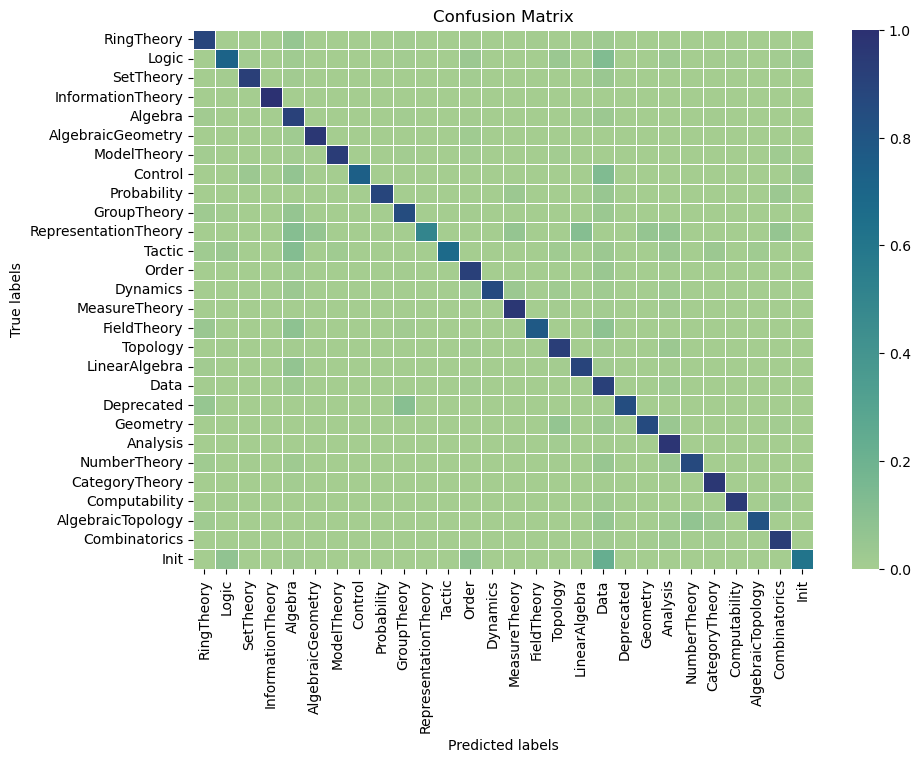

In [50]:
# Plotting using seaborn for better readability, crest color for highlighting minor errors
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, fmt='g', cmap='crest', xticklabels=indexs.keys(), yticklabels=indexs.keys(), linewidth=0.5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
